In [ ]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


# =============================
# A) Baseline model
# =============================
class BaselineModel:
    """
    Baseline model:
    - learns the churn rate from training data
    - predicts always the majority class
    - returns a constant probability
    """
    def __init__(self):
        self.majority_class_ = None
        self.p_churn_ = None

    def fit(self, X, y):
        y = np.array(y)
        self.p_churn_ = float((y == 1).mean())
        self.majority_class_ = 1 if self.p_churn_ >= 0.5 else 0
        return self

    def predict(self, X):
        if self.majority_class_ is None:
            raise ValueError("BaselineModel not fitted yet.")
        return np.full(len(X), self.majority_class_, dtype=int)

    def predict_proba(self, X):
        if self.p_churn_ is None:
            raise ValueError("BaselineModel not fitted yet.")
        n = len(X)
        p1 = np.full(n, self.p_churn_, dtype=float)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])


# =============================
# B) Metrics (for all models)
# =============================
def compute_metrics(y_true, y_pred, y_proba):
    """Compute the metrics we want to report."""
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["f1"] = f1_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)

    # ROC-AUC needs probabilities
    try:
        metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
    except Exception:
        metrics["roc_auc"] = None

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics["tn"], metrics["fp"], metrics["fn"], metrics["tp"] = tn, fp, fn, tp
    return metrics


# =============================
# C) Train/Val/Test split
# =============================
def make_splits(df, target="churned", seed=42):
    """
    70% train, 15% val, 15% test.
    """
    train_df, temp_df = train_test_split(
        df, test_size=0.30, random_state=seed, stratify=df[target]
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.50, random_state=seed, stratify=temp_df[target]
    )
    return train_df, val_df, test_df


# =============================
# D) Simple preprocessing
# =============================
def preprocess(train_df, val_df, test_df, target="churned"):
    """
    What we do:
    1) drop customer_id if it exists
    2) split into X/y
    3) fill missing values (median for numbers, "Unknown" for categories)
    4) encode categoricals (based on train columns)
    5) scale numeric columns (based on train)
    """
    drop_cols = ["customer_id"] if "customer_id" in train_df.columns else []

    # Separate features and target
    X_train = train_df.drop(columns=[target] + drop_cols)
    y_train = train_df[target].astype(int)

    X_val = val_df.drop(columns=[target] + drop_cols)
    y_val = val_df[target].astype(int)

    X_test = test_df.drop(columns=[target] + drop_cols)
    y_test = test_df[target].astype(int)

    # Identify categorical columns from train
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    # Fill missing numeric values with median from TRAIN
    for col in num_cols:
        med = X_train[col].median()
        X_train[col] = X_train[col].fillna(med)
        X_val[col] = X_val[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

    # Fill missing categorical values with "Unknown"
    for col in cat_cols:
        X_train[col] = X_train[col].fillna("Unknown")
        X_val[col] = X_val[col].fillna("Unknown")
        X_test[col] = X_test[col].fillna("Unknown")

    # One-hot encoding
    X_train_enc = pd.get_dummies(X_train, columns=cat_cols)
    X_val_enc = pd.get_dummies(X_val, columns=cat_cols)
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols)

    # Align columns so val/test match train
    X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

    # Scale numeric features (helps LR and MLP)
    scaler = StandardScaler()
    X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
    X_val_enc[num_cols] = scaler.transform(X_val_enc[num_cols])
    X_test_enc[num_cols] = scaler.transform(X_test_enc[num_cols])

    return X_train_enc, y_train, X_val_enc, y_val, X_test_enc, y_test


# =============================
# E) EDA
# =============================
def do_eda(df):
    print("\n--- BASIC DATA CHECKS ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())

    missing = df.isna().sum().sort_values(ascending=False)
    print("\nMissing values:")
    print(missing[missing > 0] if (missing > 0).any() else "No missing values found.")

    churn_rate = df["churned"].mean()
    print(f"\nChurn rate (full dataset): {churn_rate:.3f} ({churn_rate*100:.1f}%)")

    # Churn bar
    df["churned"].value_counts().plot(kind="bar")
    plt.title("Churned (1) vs Not Churned (0)")
    plt.xlabel("churned")
    plt.ylabel("count")
    plt.show()

    # Numeric boxplots
    numeric_cols = ["watch_hours", "avg_watch_time_per_day", "last_login_days", "monthly_fee", "number_of_profiles", "age"]
    numeric_cols = [c for c in numeric_cols if c in df.columns]

    for col in numeric_cols:
        df.boxplot(column=col, by="churned")
        plt.title(f"{col} by churned")
        plt.suptitle("")
        plt.xlabel("churned")
        plt.ylabel(col)
        plt.show()

    # Churn rate by categories
    def churn_rate_by(col):
        if col not in df.columns:
            return
        rates = df.groupby(col)["churned"].mean().sort_values(ascending=False)
        print(f"\nChurn rate by {col}:")
        print(rates)

        rates.plot(kind="bar")
        plt.title(f"Churn rate by {col}")
        plt.ylabel("churn rate")
        plt.show()

    for col in ["subscription_type", "payment_method", "region", "device", "favorite_genre", "gender"]:
        churn_rate_by(col)


# =============================
# F) Train and evaluate models
# =============================
def train_and_compare(X_train, y_train, X_val, y_val):
    results = []

    # Baseline
    base = BaselineModel().fit(X_train, y_train)
    for split_name, X, y in [("train", X_train, y_train), ("val", X_val, y_val)]:
        pred = base.predict(X)
        proba = base.predict_proba(X)[:, 1]
        results.append({"model": "Baseline", "split": split_name, **compute_metrics(y, pred, proba)})

    # Models we compare
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
        "GradientBoosting": GradientBoostingClassifier(random_state=42),
        "MLP": MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        for split_name, X, y in [("train", X_train, y_train), ("val", X_val, y_val)]:
            pred = model.predict(X)
            proba = model.predict_proba(X)[:, 1]
            results.append({"model": name, "split": split_name, **compute_metrics(y, pred, proba)})

    return pd.DataFrame(results), models


# =============================
# G) final test eval
# =============================
def evaluate_on_test(models, train_df, val_df, test_df, target="churned"):
    # retrain each model on train+val, then test
    trainval_df = pd.concat([train_df, val_df], axis=0)
    X_trainval, y_trainval, _, _, X_test, y_test = preprocess(trainval_df, val_df, test_df, target=target)

    rows = []
    for name, model in models.items():
        model.fit(X_trainval, y_trainval)
        pred = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]
        rows.append({"model": name, **compute_metrics(y_test, pred, proba)})

    return pd.DataFrame(rows).sort_values("f1", ascending=False)


# =============================
# H) Data path helper
# =============================
def find_data_path(data_path=None):
    if data_path is not None and Path(data_path).exists():
        return data_path

    # common locations
    candidates = [
        "input/WatchAlways_customer_churn.csv",
        "../input/WatchAlways_customer_churn.csv",
        "/mnt/data/WatchAlways_customer_churn.csv",
        "WatchAlways_customer_churn.csv",
    ]
    for c in candidates:
        if Path(c).exists():
            return c

    raise FileNotFoundError("CSV not found. Provide --data PATH or move file to input/.")


# =============================
# I) Main runner
# =============================
def main(data_path=None, final_test=False, do_eda_plots=True):
    data_path = find_data_path(data_path)
    print("Using data:", data_path)

    df = pd.read_csv(data_path)

    if do_eda_plots:
        do_eda(df)

    train_df, val_df, test_df = make_splits(df, target="churned", seed=42)
    X_train, y_train, X_val, y_val, X_test, y_test = preprocess(train_df, val_df, test_df, target="churned")

    results_df, models = train_and_compare(X_train, y_train, X_val, y_val)

    Path("results").mkdir(exist_ok=True)
    results_df.to_csv("results/metrics_train_val.csv", index=False)

    val_only = results_df[results_df["split"] == "val"].sort_values("f1", ascending=False)
    print("\n--- VALIDATION RESULTS (sorted by F1) ---")
    print(val_only[["model", "accuracy", "f1", "roc_auc", "precision", "recall"]].to_string(index=False))
    print("\nSaved: results/metrics_train_val.csv")

    if final_test:
        print("\n--- FINAL TEST EVALUATION (use only at the end) ---")
        test_results = evaluate_on_test(models, train_df, val_df, test_df, target="churned")
        test_results.to_csv("results/metrics_test.csv", index=False)
        print(test_results[["model", "accuracy", "f1", "roc_auc", "precision", "recall"]].to_string(index=False))
        print("\nSaved: results/metrics_test.csv")

    return results_df, val_only


# =============================
# J) CLI (terminal usage only)
# =============================
def cli():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, default=None, help="Path to CSV")
    parser.add_argument("--final_test", action="store_true", help="Run final test (only at the end)")
    parser.add_argument("--no_eda", action="store_true", help="Skip EDA plots")
    args = parser.parse_args()

    main(data_path=args.data, final_test=args.final_test, do_eda_plots=(not args.no_eda))


if __name__ == "__main__":
    import sys
    if "ipykernel" in sys.modules:
        print("Loaded in notebook. Run: main()")
    else:
        cli()


Loaded in notebook. Run: main()


Using data: ../input/WatchAlways_customer_churn.csv

--- BASIC DATA CHECKS ---
Shape: (5000, 14)
Columns: ['customer_id', 'age', 'gender', 'subscription_type', 'watch_hours', 'last_login_days', 'region', 'device', 'monthly_fee', 'churned', 'payment_method', 'number_of_profiles', 'avg_watch_time_per_day', 'favorite_genre']

Missing values:
No missing values found.

Churn rate (full dataset): 0.503 (50.3%)


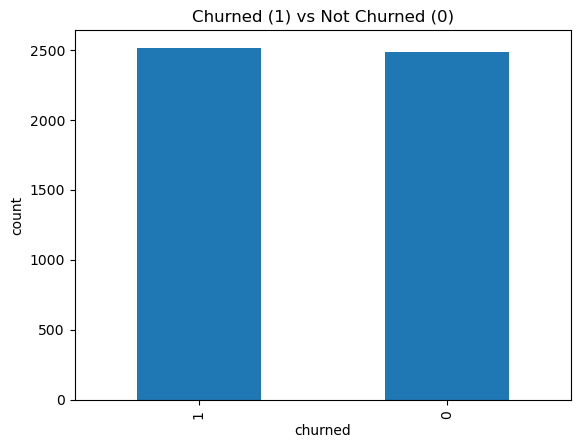

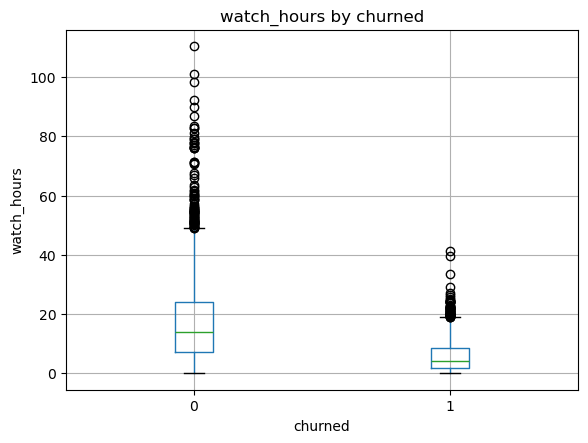

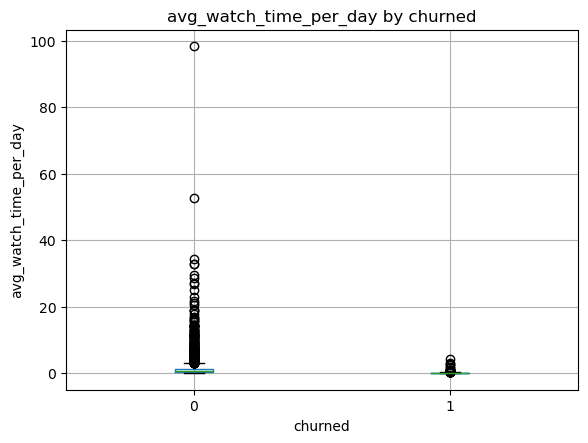

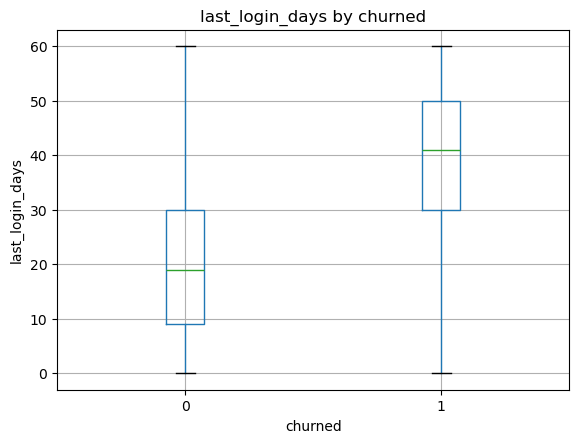

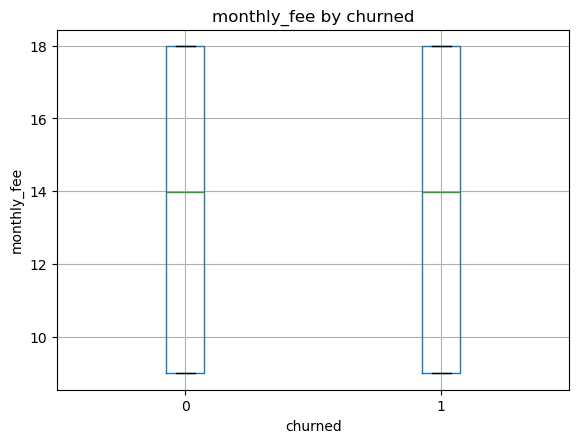

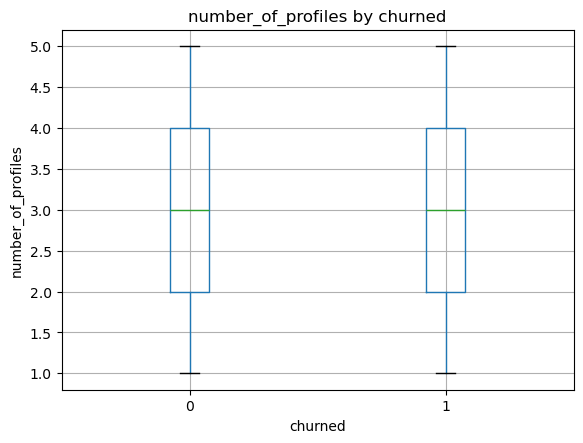

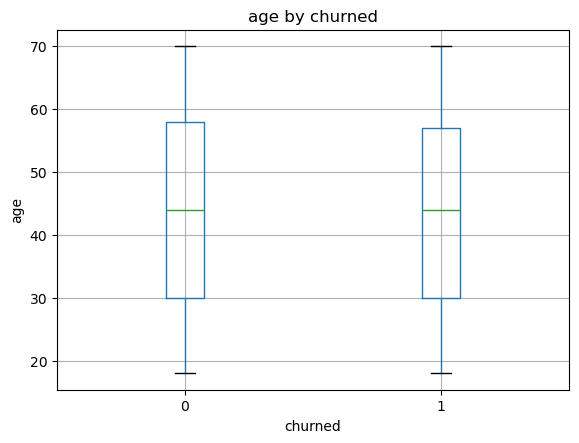


Churn rate by subscription_type:
subscription_type
Basic       0.618302
Standard    0.454435
Premium     0.437094
Name: churned, dtype: float64


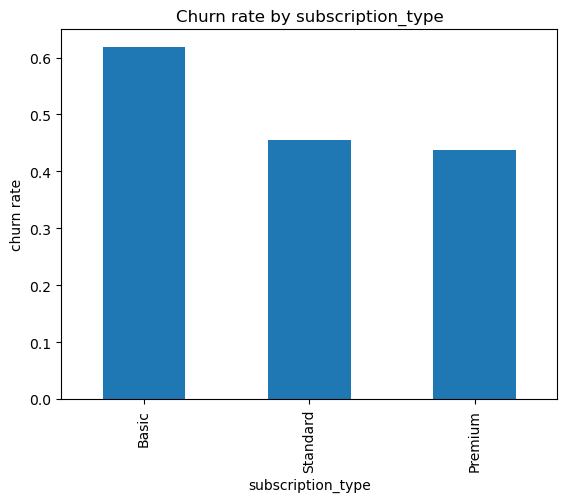


Churn rate by payment_method:
payment_method
Crypto         0.596985
Gift Card      0.577869
PayPal         0.470760
Debit Card     0.436893
Credit Card    0.435766
Name: churned, dtype: float64


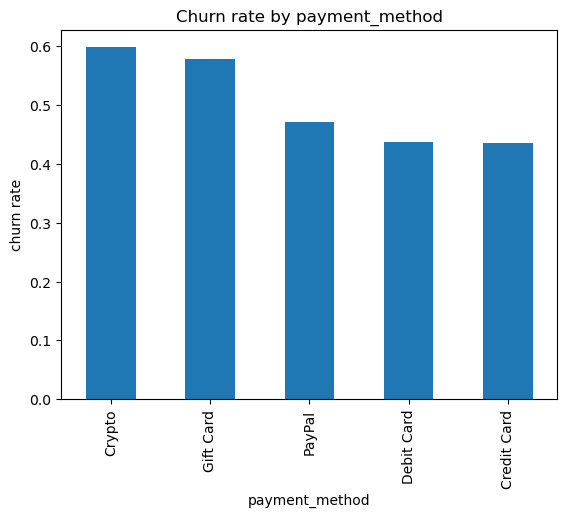


Churn rate by region:
region
Europe           0.516724
South America    0.514318
Asia             0.506540
Oceania          0.500654
North America    0.494712
Africa           0.483188
Name: churned, dtype: float64


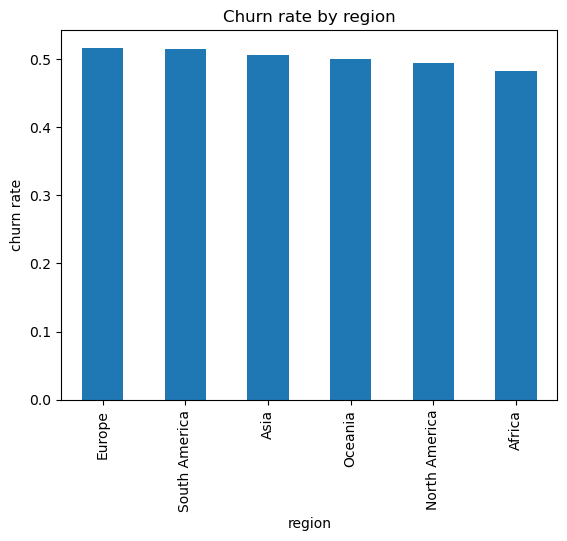


Churn rate by device:
device
Laptop     0.517893
Mobile     0.504980
Tablet     0.500000
TV         0.499496
Desktop    0.492097
Name: churned, dtype: float64


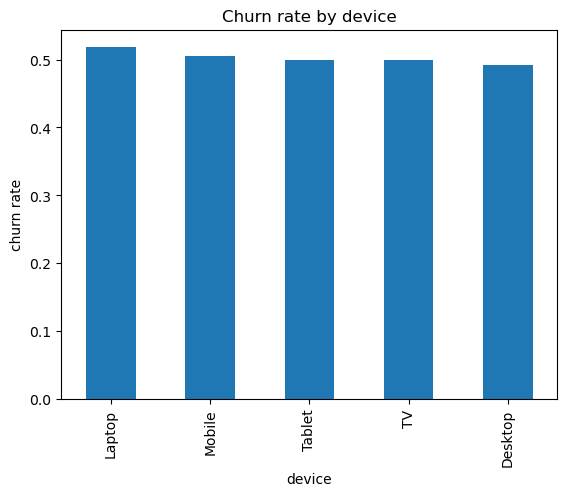


Churn rate by favorite_genre:
favorite_genre
Action         0.523673
Drama          0.522572
Horror         0.514727
Documentary    0.507545
Comedy         0.499270
Romance        0.482759
Sci-Fi         0.470833
Name: churned, dtype: float64


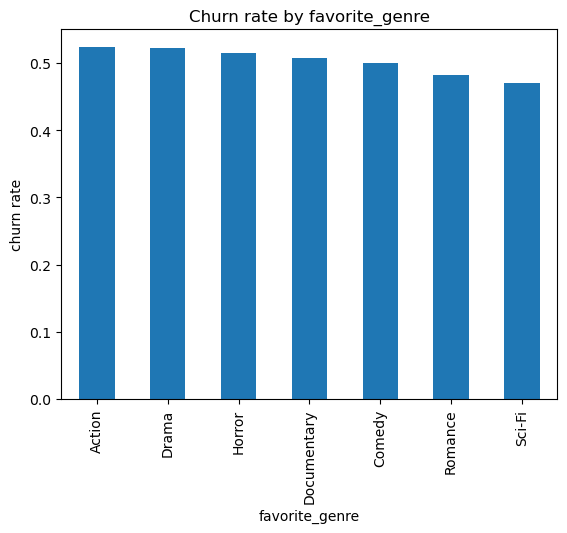


Churn rate by gender:
gender
Female    0.510812
Male      0.500000
Other     0.497859
Name: churned, dtype: float64


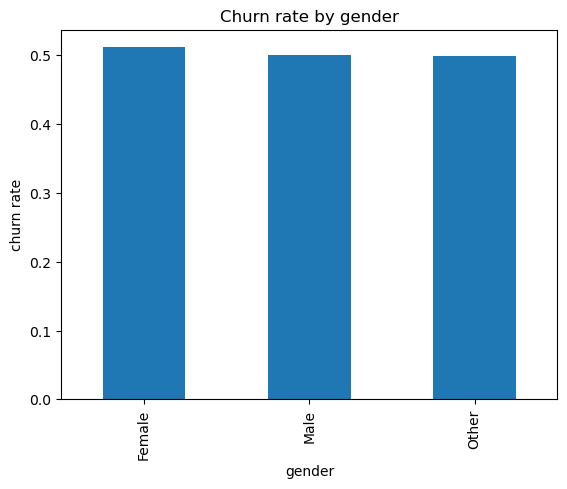


--- VALIDATION RESULTS (sorted by F1) ---
             model  accuracy       f1  roc_auc  precision   recall
  GradientBoosting  0.989333 0.989362 0.998251   0.992000 0.986737
      RandomForest  0.980000 0.980185 0.997340   0.976316 0.984085
               MLP  0.914667 0.914894 0.974257   0.917333 0.912467
LogisticRegression  0.886667 0.888011 0.968340   0.882199 0.893899
          Baseline  0.502667 0.669033 0.500000   0.502667 1.000000

Saved: results/metrics_train_val.csv


(                model  split  accuracy        f1  precision    recall  \
 0            Baseline  train  0.503143  0.669454   0.503143  1.000000   
 1            Baseline    val  0.502667  0.669033   0.502667  1.000000   
 2  LogisticRegression  train  0.897429  0.898444   0.895152  0.901760   
 3  LogisticRegression    val  0.886667  0.888011   0.882199  0.893899   
 4        RandomForest  train  1.000000  1.000000   1.000000  1.000000   
 5        RandomForest    val  0.980000  0.980185   0.976316  0.984085   
 6    GradientBoosting  train  0.994857  0.994878   0.997148  0.992618   
 7    GradientBoosting    val  0.989333  0.989362   0.992000  0.986737   
 8                 MLP  train  1.000000  1.000000   1.000000  1.000000   
 9                 MLP    val  0.914667  0.914894   0.917333  0.912467   
 
     roc_auc    tn    fp   fn    tp  
 0  0.500000     0  1739    0  1761  
 1  0.500000     0   373    0   377  
 2  0.968660  1553   186  173  1588  
 3  0.968340   328    45   40   

In [22]:
main()